# Dune Glider optimization code

This is the main optimization code for Dune Glider. 

Lets use `aerosandbox` to extract aerodynamic coefficients from an aircraft model.

In [1]:
%matplotlib widget
import aerosandbox as asb
import aerosandbox.numpy as np
from pathlib import Path
from dataclasses import dataclass, field
import matplotlib.pyplot as plt
import aerosandbox.tools.pretty_plots as p
import scipy.optimize
from dune_plot_tools import *
from aircraft_model import WingSection
from dune_opt import OptScore



## Aircraft definition and simulation

We define an aircraft based on 3 main parameters:
- Wing root chord
- Wing tip chord
- Wing sweep

This version of the aircraft has only one wing section. The method used to get the aerodynamic coefficients is the Aerobuildup method.

Considerations:

- We use a take-off speed of $8 m/s$
- The max wing span is $3 m$

In [2]:
def simulate_aircraft(wing_root_chord = 1, 
                      wing_tip_chord = 1,
                      wing_sweep = np.radians(40),
                      should_plot=False):
    
    wing_max_span = 3   
    wing_root_pnt = np.array([0, 0, 0])
    wing_sec1 = WingSection( span_tip=(wing_max_span)/2,
                            sweep = wing_sweep,
                            chord_tip = wing_tip_chord,
                            airfoil = asb.Airfoil("l1003"),
                            init_point = wing_root_pnt,
                            init_chord = wing_root_chord)

    def get_plane(xyz_ref=np.array([0, 0, 0])):
        return asb.Airplane(
            name="Dune Glider",
            xyz_ref=xyz_ref,  # CG location
            wings=[
                asb.Wing(
                    name="Main Wing",
                    symmetric=True,  # Should this wing be mirrored across the XZ plane?
                    xsecs=[  # The wing's cross ("X") sections
                        asb.WingXSec(  # Root
                            xyz_le = wing_root_pnt,  # Coordinates of the XSec's leading edge, relative to the wing's leading edge.
                            chord = wing_root_chord,
                            twist = 0.0,  # degrees
                            airfoil = asb.Airfoil("l1003")
                        ),
                        asb.WingXSec(
                            xyz_le = wing_sec1.get_wing_tip_offset(),
                            chord = wing_sec1.chord_tip,
                            twist = 0,
                            airfoil= wing_sec1.airfoil
                        ),
                    ]
                )
            ]
        )

    # Get the aerodynamic center of the aircraft and add the CG one meter below it
    ac = get_plane().aerodynamic_center() + np.array([0, 0, -1 ])

    # Get the airplane with the corrected CG
    airplane = get_plane(ac)

    # Plot airplane
    if should_plot:
        airplane.draw_three_view()

    # AEROBUILDUP METHOD
    op_point = asb.OperatingPoint(
        atmosphere=asb.Atmosphere(altitude=0),
        velocity = 8,  # m/s
    )
    xyz_ref = ac


    ab_op_point = op_point.copy()
    ab_op_point.alpha = np.linspace(-12, 25, 50)
    aerobuildup_aero = asb.AeroBuildup(
        airplane=airplane,
        op_point=ab_op_point,
        xyz_ref=xyz_ref
    ).run()

    aerobuildup_aero["alpha"] = ab_op_point.alpha
    aerobuildup_aero["CL/CD"] = np.divide(aerobuildup_aero["CL"], aerobuildup_aero["CD"])
    
    # PLOT:
    if should_plot:
        plot_polars(aerobuildup_aero, "AeroBuildup method")

    return aerobuildup_aero, airplane

## Cost function

TODO: There are a lot to explain here

In [3]:
def function_to_optimize(x):
    aero, _ = simulate_aircraft(wing_root_chord = x[0],
                                wing_tip_chord = x[1],
                                wing_sweep = x[2])
    
    # Calculate optimization function

    # We maximize the CL/CD
    max_clcd = np.max(aero['CL/CD'])
    max_clcd_alpha = np.argmax(aero['CL/CD'])

    # CM should be below zero in all alpha above zero. Same in the opposite direction 
    # We can create a "score" using a sigmoid function
    npoints = len(aero['Cm'])
    sum_score_cm = 0
    for i in range(npoints):
        if aero['alpha'][i] >= max_clcd_alpha:
            y = 1 / (1 + np.exp((aero['Cm'][i]-0.05)*100))
            sum_score_cm += y
            # print(aero['alpha'][i],", ", aero['Cm'][i], ", ", y)
        else:
            y = 1 / (1 + np.exp(-(aero['Cm'][i]+0.05)*100))
            sum_score_cm += y
            # print(aero['alpha'][i],", ", aero['Cm'][i], ", ", y)

    # If the score is 1, it is perfect
    normalized_avg_cm_score = sum_score_cm/npoints
    normalized_avg_cm_score = 1

    cl_alpha_in_max_clcd = aero['CL'][max_clcd_alpha]
    cm_alpha_in_max_clcd = aero['Cm'][max_clcd_alpha]

    # We expect the Cm around the max CL/CD point is near zero as possible, so we use a d(tanh)/dx function
    score_cm_alpha_max_clcd = 1-np.power(cm_alpha_in_max_clcd*(1/0.2),2)

    score = max_clcd*normalized_avg_cm_score*cl_alpha_in_max_clcd*score_cm_alpha_max_clcd
    return -(score)

## Callback function

We can define a callback to store the local minimum for each basinhopping local minimum. We can also store each iteration's aircraft.

In [4]:
optscore = OptScore()
# Callback function to store information about the local minimum
def local_min_callback(x, f, accepted):
    if accepted:
        aero, airplane = simulate_aircraft(wing_root_chord = x[0],
                                           wing_tip_chord = x[1],
                                           wing_sweep = x[2])
        optscore.add_local_min(x, f, aero, airplane)

def all_steps_callback(x):
    aero, airplane = simulate_aircraft(wing_root_chord = x[0],
                                       wing_tip_chord = x[1],
                                       wing_sweep = x[2])
    optscore.add_step_to_eval_list(x, function_to_optimize(x), aero, airplane)

## Run optimization

For this optimization we are using the [basinhopping](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.basinhopping.html) algorithm to find the global minimum of the function. This method will use another method [L-BFGS-B](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-lbfgsb.html) to find the local minimum. We set a number of max iteration of 20.

The `L-BFGS-B` allows the use of bounderies for the variables. We limit the root and tip chord to have a value between $5 cm$ and $2 m$ and the sweep angle between $0º$ and $45º$

In [5]:
#               wing_root_chord   wing_tip_chord   wing_sweep
init_values  = [1,                1,                np.radians(0)]
bound_values = [(0.05, 2),        (0.05, 2),       (np.radians(0), np.radians(45))]

minimizer_kwargs = {"method": "L-BFGS-B", "bounds":bound_values, 'options':{"disp": True}}
# minimizer_kwargs = {"method": "L-BFGS-B", "bounds":bound_values, "callback":all_steps_callback, 'options':{"disp": True}}
xopt = scipy.optimize.basinhopping(function_to_optimize, x0=init_values, niter=100, minimizer_kwargs=minimizer_kwargs, callback=local_min_callback)

aero, airplane = simulate_aircraft(wing_root_chord = xopt.x[0],
                                   wing_tip_chord = xopt.x[1],
                                   wing_sweep = xopt.x[2])
optscore.set_global_min(xopt.x, xopt.fun, aero, airplane)

## Plotting the optimizer population

The following plot shows the score in color. The axis represents the CL and CL/CD of each invidious. 

Click in the point to plot the aircraft in 3D. 

Clicked on Point 17
19


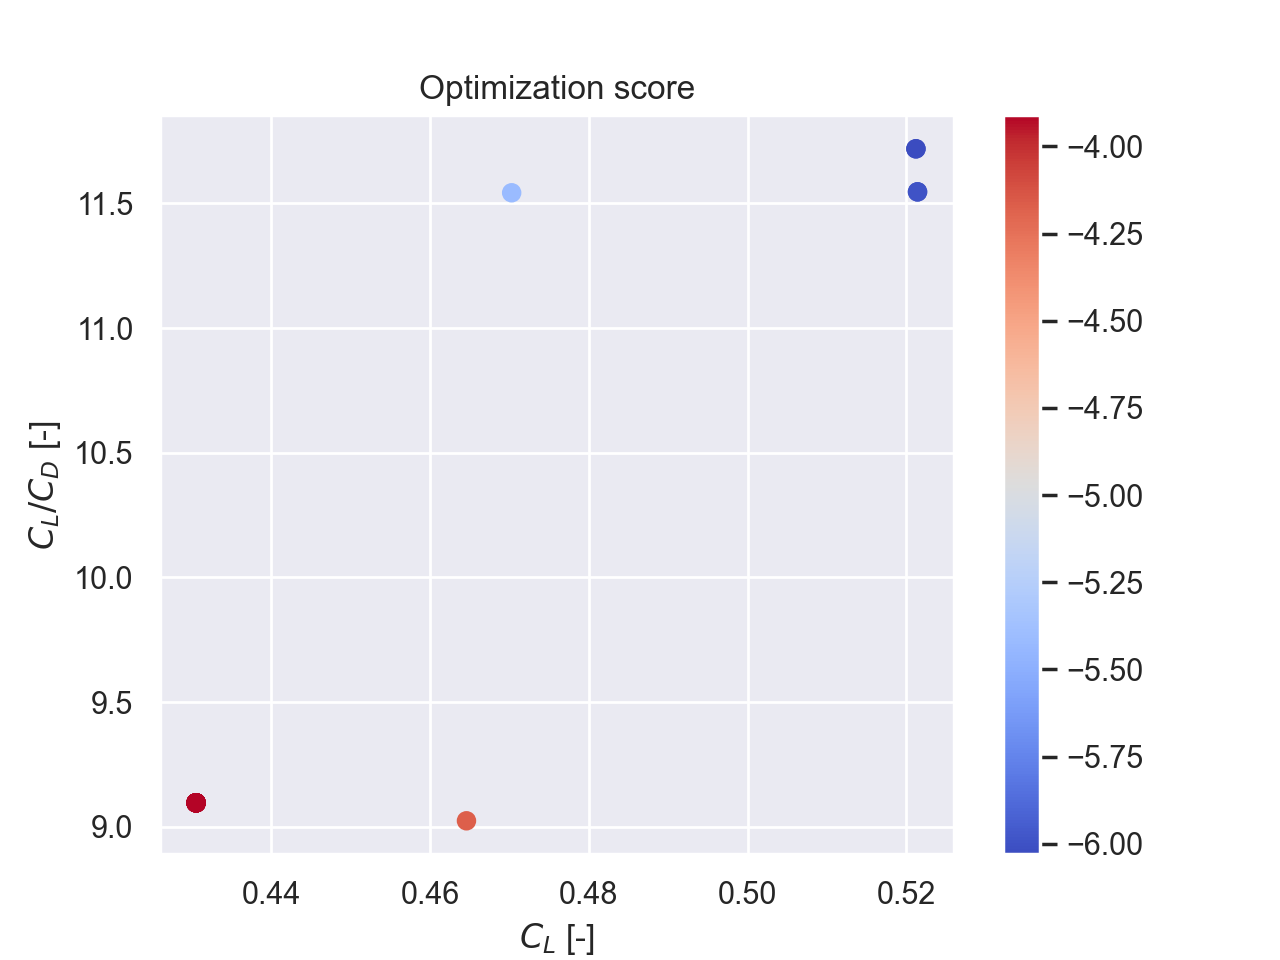

wing_root_chord: 1.2848175995041313
wing_tip_chord: 0.05
wing_sweep: 17.05129202629838


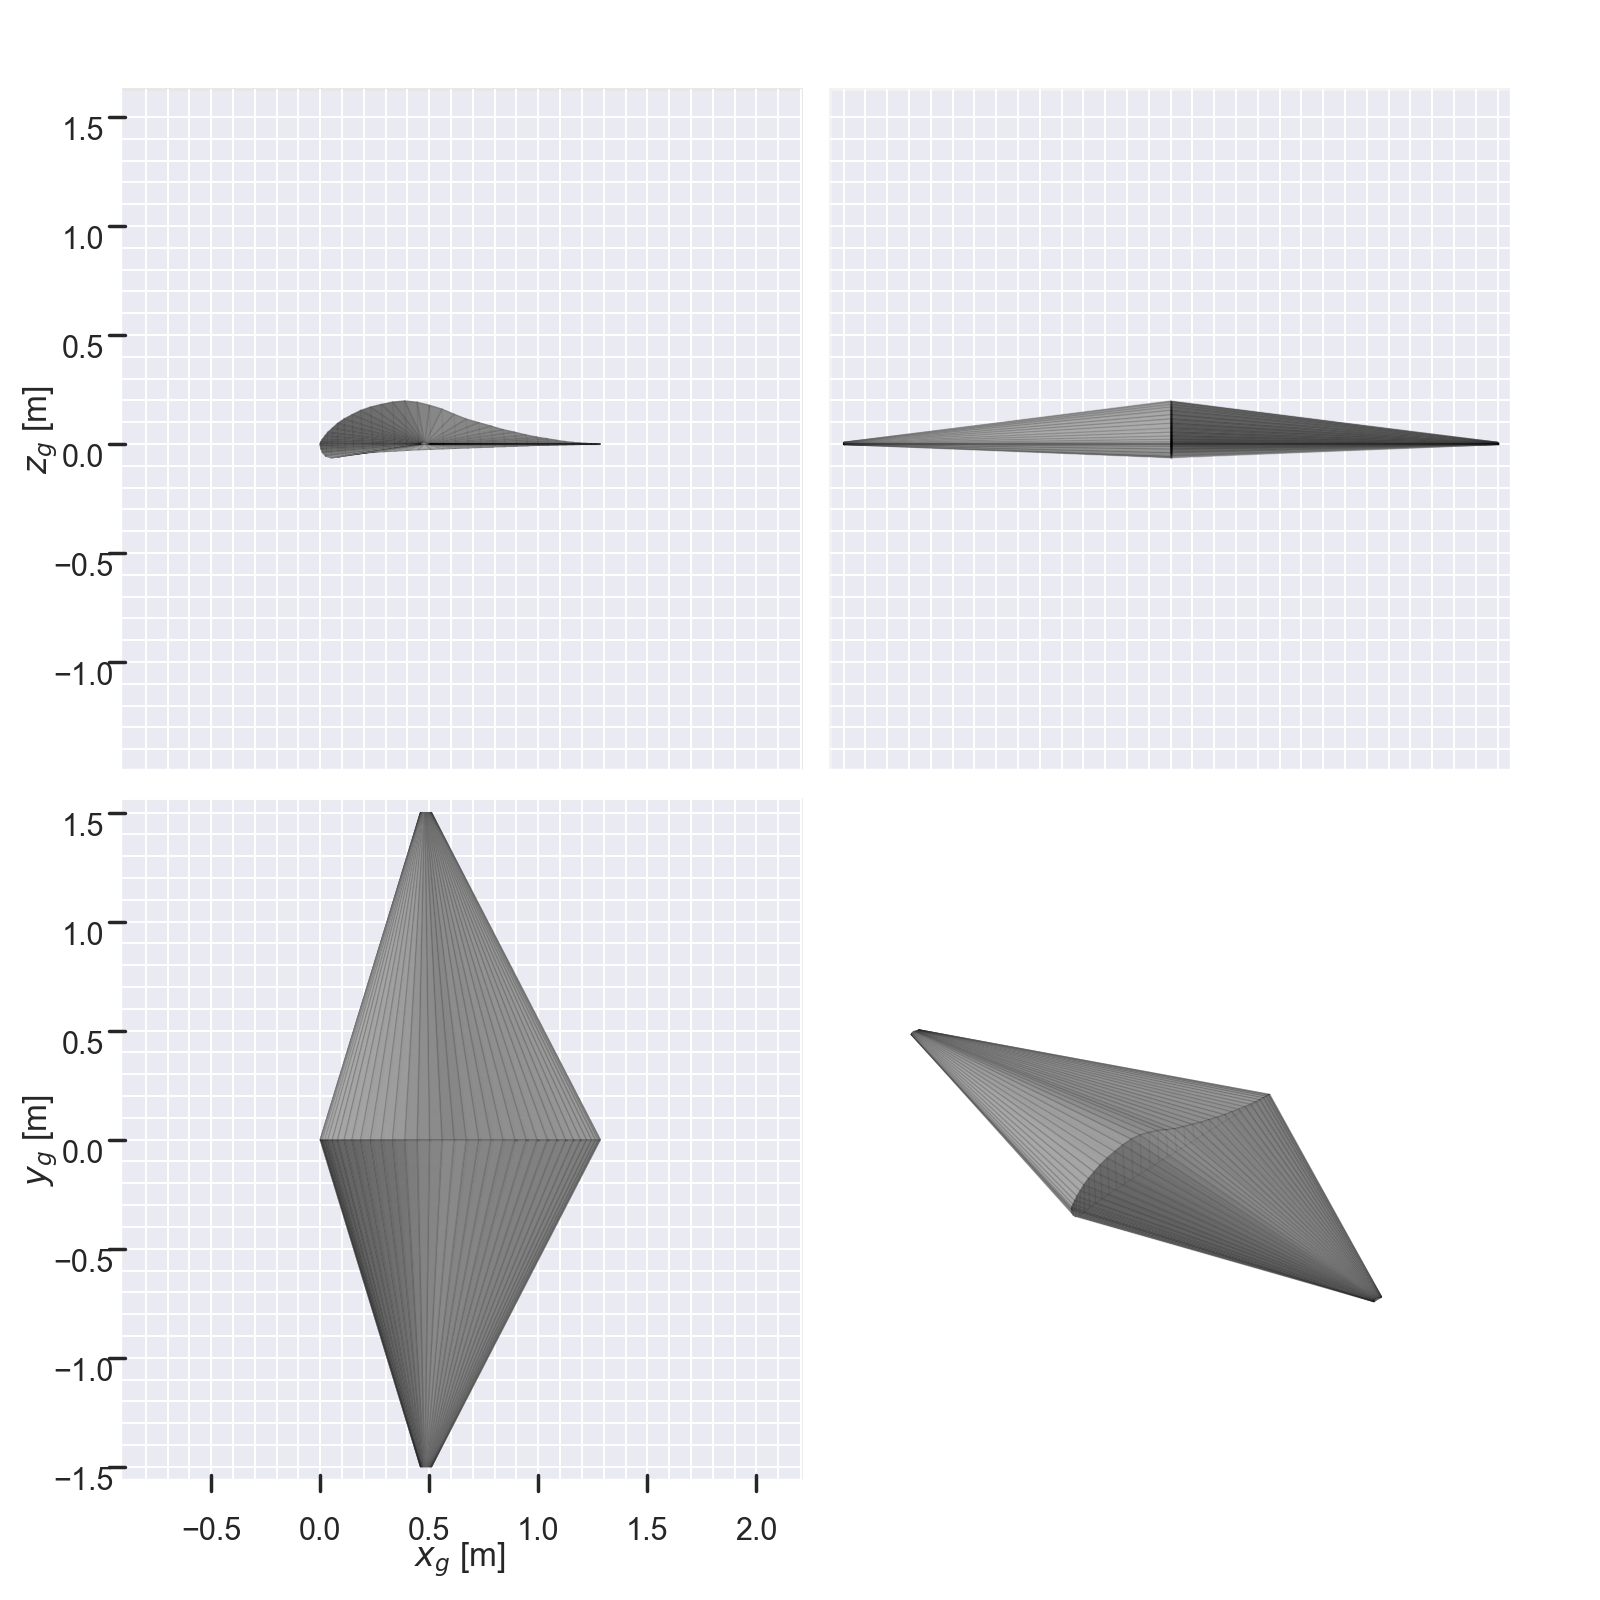

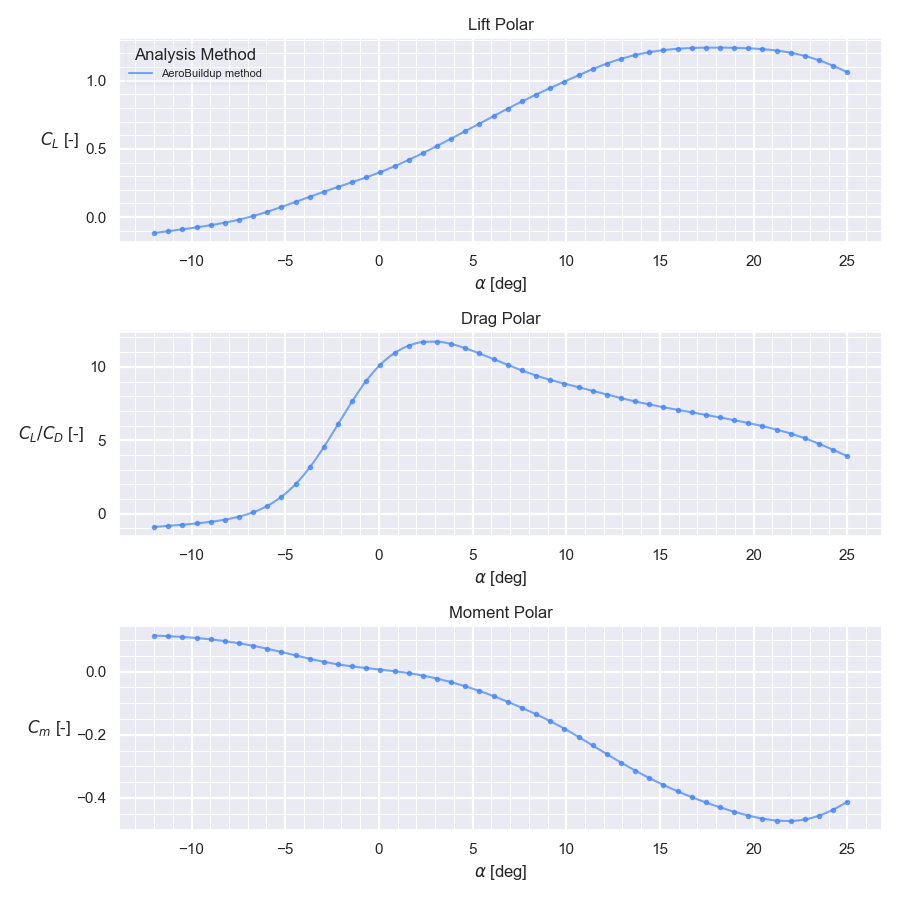

In [ ]:
plot_opt_score(optscore)

In [7]:
print(xopt.message)
print(xopt.x)
print(xopt.fun)
print(f"wing_root_chord: {xopt.x[0]}")
print(f"wing_tip_chord: {xopt.x[1]}")
print(f"wing_sweep: {xopt.x[2]*180/np.pi}")


['requested number of basinhopping iterations completed successfully']
[1.2848176  0.05       0.29760119]
-6.030721195039699
wing_root_chord: 1.2848175995041313
wing_tip_chord: 0.05
wing_sweep: 17.05129202629838
